# TODO:

* Calcular información mutua para todos los ficheros con resoluciones grandes
* Función transferencia info, que es copiar la de informacion mutua y devolver dividiendo entre la entropia <b>DONE</b>
* Graficas interspike

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
import pickle

In [17]:
from_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
              "./DatosSinapsisArtificial/TrozoR_bin.csv",
              "./DatosSinapsisArtificial/TrozoG_bin.csv"]
cols = [["LP_bin", "VD_bin"],
        ["LP_bin", "VD_bin"],
        ["LP_bin", "VD_bin"]]
to_files = ["dataC.pkl",
            "dataR.pkl",
            "dataG.pkl"]
resolutions = [150, 150, 150]
word_lens = [8, 8, 8]
col_names = [f"word_len {i}" for i in range(max(word_lens))]
row_names = [f"resolution {i}" for i in range(max(resolutions))]
for n in range(len(from_files)):
    df = pd.read_csv(from_files[n])[cols[n]]
    df = df.astype({cols[n][0]:'u1', cols[n][0]:'u1'})
    try:
        with open(to_files[n], "rb") as f:
            data = pickle.load(f)
    except FileNotFoundError:
        data = {
            "transfer_info_col1_col2" : pd.DataFrame(columns = col_names, index = row_names),
            "transfer_info_col2_col1" : pd.DataFrame(columns = col_names, index = row_names),
            "mutual_info" : pd.DataFrame(columns = col_names, index = row_names),
            "col1_entropy" : pd.DataFrame(columns = col_names, index = row_names),
            "col2_entropy" : pd.DataFrame(columns = col_names, index = row_names),
            "joined_entropy" : pd.DataFrame(columns = col_names, index = row_names)
        }
        data["transfer_info_col1_col2"][:] = 0
        data["transfer_info_col2_col1"][:] = 0
        data["mutual_info"][:] = 0
        data["col1_entropy"][:] = 0
        data["col2_entropy"][:] = 0
        data["joined_entropy"][:] = 0
    for i in range(resolutions[n]):
        for j in range(word_lens[n]):
            if (data["transfer_info_col1_col2"].loc[row_names[i], col_names[j]] != 0 and
                data["transfer_info_col2_col1"].loc[row_names[i], col_names[j]] != 0 and
                data["mutual_info"].loc[row_names[i], col_names[j]] != 0 and
                data["col1_entropy"].loc[row_names[i], col_names[j]] != 0 and
                data["col2_entropy"].loc[row_names[i], col_names[j]] != 0 and
                data["joined_entropy"].loc[row_names[i], col_names[j]] != 0):
                print(f"Previamente calculado {to_files[n]}: resolución={i+1}, palabra={j+1} en la posicion[{i}][{j}]")
                continue
            print(f"Comienzo cálculo resolución={i+1}, palabra={j+1} en la posicion[{i}][{j}]")
            tr, mi, e, ej = transfer_info(resolution(df, i+1), cols[n], j+1)
            data["transfer_info_col1_col2"].loc[row_names[i], col_names[j]] = tr[0]
            data["transfer_info_col2_col1"].loc[row_names[i], col_names[j]] = tr[1]
            data["mutual_info"].loc[row_names[i], col_names[j]] = mi
            data["col1_entropy"].loc[row_names[i], col_names[j]] = e[0]
            data["col2_entropy"].loc[row_names[i], col_names[j]] = e[1]
            data["joined_entropy"].loc[row_names[i], col_names[j]] = ej
            print(f"Calculado {to_files[n]}: resolución={i+1}, palabra={j+1} en la posicion[{i}][{j}]")
            with open(to_files[n], "wb") as f:
                pickle.dump(data, f)

Previamente calculado dataC.pkl: resolución=1, palabra=1 en la posicion[0][0]
Previamente calculado dataC.pkl: resolución=1, palabra=2 en la posicion[0][1]
Previamente calculado dataC.pkl: resolución=1, palabra=3 en la posicion[0][2]
Previamente calculado dataC.pkl: resolución=1, palabra=4 en la posicion[0][3]
Previamente calculado dataC.pkl: resolución=1, palabra=5 en la posicion[0][4]
Previamente calculado dataC.pkl: resolución=1, palabra=6 en la posicion[0][5]
Previamente calculado dataC.pkl: resolución=1, palabra=7 en la posicion[0][6]
Previamente calculado dataC.pkl: resolución=1, palabra=8 en la posicion[0][7]
Previamente calculado dataC.pkl: resolución=2, palabra=1 en la posicion[1][0]
Previamente calculado dataC.pkl: resolución=2, palabra=2 en la posicion[1][1]
Previamente calculado dataC.pkl: resolución=2, palabra=3 en la posicion[1][2]
Previamente calculado dataC.pkl: resolución=2, palabra=4 en la posicion[1][3]
Previamente calculado dataC.pkl: resolución=2, palabra=5 en la p

Previamente calculado dataR.pkl: resolución=1, palabra=1 en la posicion[0][0]
Previamente calculado dataR.pkl: resolución=1, palabra=2 en la posicion[0][1]
Previamente calculado dataR.pkl: resolución=1, palabra=3 en la posicion[0][2]
Previamente calculado dataR.pkl: resolución=1, palabra=4 en la posicion[0][3]
Previamente calculado dataR.pkl: resolución=1, palabra=5 en la posicion[0][4]
Previamente calculado dataR.pkl: resolución=1, palabra=6 en la posicion[0][5]
Previamente calculado dataR.pkl: resolución=1, palabra=7 en la posicion[0][6]
Previamente calculado dataR.pkl: resolución=1, palabra=8 en la posicion[0][7]
Previamente calculado dataR.pkl: resolución=2, palabra=1 en la posicion[1][0]
Previamente calculado dataR.pkl: resolución=2, palabra=2 en la posicion[1][1]
Previamente calculado dataR.pkl: resolución=2, palabra=3 en la posicion[1][2]
Previamente calculado dataR.pkl: resolución=2, palabra=4 en la posicion[1][3]
Previamente calculado dataR.pkl: resolución=2, palabra=5 en la p

Comienzo cálculo resolución=1, palabra=1 en la posicion[0][0]
Calculado dataG.pkl: resolución=1, palabra=1 en la posicion[0][0]
Comienzo cálculo resolución=1, palabra=2 en la posicion[0][1]
Calculado dataG.pkl: resolución=1, palabra=2 en la posicion[0][1]
Comienzo cálculo resolución=1, palabra=3 en la posicion[0][2]
Calculado dataG.pkl: resolución=1, palabra=3 en la posicion[0][2]
Comienzo cálculo resolución=1, palabra=4 en la posicion[0][3]
Calculado dataG.pkl: resolución=1, palabra=4 en la posicion[0][3]
Comienzo cálculo resolución=1, palabra=5 en la posicion[0][4]
Calculado dataG.pkl: resolución=1, palabra=5 en la posicion[0][4]
Comienzo cálculo resolución=1, palabra=6 en la posicion[0][5]
Calculado dataG.pkl: resolución=1, palabra=6 en la posicion[0][5]
Comienzo cálculo resolución=1, palabra=7 en la posicion[0][6]
Calculado dataG.pkl: resolución=1, palabra=7 en la posicion[0][6]
Comienzo cálculo resolución=1, palabra=8 en la posicion[0][7]
Calculado dataG.pkl: resolución=1, palabra

Calculado dataG.pkl: resolución=9, palabra=1 en la posicion[8][0]
Comienzo cálculo resolución=9, palabra=2 en la posicion[8][1]
Calculado dataG.pkl: resolución=9, palabra=2 en la posicion[8][1]
Comienzo cálculo resolución=9, palabra=3 en la posicion[8][2]
Calculado dataG.pkl: resolución=9, palabra=3 en la posicion[8][2]
Comienzo cálculo resolución=9, palabra=4 en la posicion[8][3]
Calculado dataG.pkl: resolución=9, palabra=4 en la posicion[8][3]
Comienzo cálculo resolución=9, palabra=5 en la posicion[8][4]
Calculado dataG.pkl: resolución=9, palabra=5 en la posicion[8][4]
Comienzo cálculo resolución=9, palabra=6 en la posicion[8][5]
Calculado dataG.pkl: resolución=9, palabra=6 en la posicion[8][5]
Comienzo cálculo resolución=9, palabra=7 en la posicion[8][6]
Calculado dataG.pkl: resolución=9, palabra=7 en la posicion[8][6]
Comienzo cálculo resolución=9, palabra=8 en la posicion[8][7]
Calculado dataG.pkl: resolución=9, palabra=8 en la posicion[8][7]
Comienzo cálculo resolución=10, palabr

Calculado dataG.pkl: resolución=16, palabra=8 en la posicion[15][7]
Comienzo cálculo resolución=17, palabra=1 en la posicion[16][0]
Calculado dataG.pkl: resolución=17, palabra=1 en la posicion[16][0]
Comienzo cálculo resolución=17, palabra=2 en la posicion[16][1]
Calculado dataG.pkl: resolución=17, palabra=2 en la posicion[16][1]
Comienzo cálculo resolución=17, palabra=3 en la posicion[16][2]
Calculado dataG.pkl: resolución=17, palabra=3 en la posicion[16][2]
Comienzo cálculo resolución=17, palabra=4 en la posicion[16][3]
Calculado dataG.pkl: resolución=17, palabra=4 en la posicion[16][3]
Comienzo cálculo resolución=17, palabra=5 en la posicion[16][4]
Calculado dataG.pkl: resolución=17, palabra=5 en la posicion[16][4]
Comienzo cálculo resolución=17, palabra=6 en la posicion[16][5]
Calculado dataG.pkl: resolución=17, palabra=6 en la posicion[16][5]
Comienzo cálculo resolución=17, palabra=7 en la posicion[16][6]
Calculado dataG.pkl: resolución=17, palabra=7 en la posicion[16][6]
Comienzo

Calculado dataG.pkl: resolución=24, palabra=7 en la posicion[23][6]
Comienzo cálculo resolución=24, palabra=8 en la posicion[23][7]
Calculado dataG.pkl: resolución=24, palabra=8 en la posicion[23][7]
Comienzo cálculo resolución=25, palabra=1 en la posicion[24][0]
Calculado dataG.pkl: resolución=25, palabra=1 en la posicion[24][0]
Comienzo cálculo resolución=25, palabra=2 en la posicion[24][1]
Calculado dataG.pkl: resolución=25, palabra=2 en la posicion[24][1]
Comienzo cálculo resolución=25, palabra=3 en la posicion[24][2]
Calculado dataG.pkl: resolución=25, palabra=3 en la posicion[24][2]
Comienzo cálculo resolución=25, palabra=4 en la posicion[24][3]
Calculado dataG.pkl: resolución=25, palabra=4 en la posicion[24][3]
Comienzo cálculo resolución=25, palabra=5 en la posicion[24][4]
Calculado dataG.pkl: resolución=25, palabra=5 en la posicion[24][4]
Comienzo cálculo resolución=25, palabra=6 en la posicion[24][5]
Calculado dataG.pkl: resolución=25, palabra=6 en la posicion[24][5]
Comienzo

Calculado dataG.pkl: resolución=32, palabra=6 en la posicion[31][5]
Comienzo cálculo resolución=32, palabra=7 en la posicion[31][6]
Calculado dataG.pkl: resolución=32, palabra=7 en la posicion[31][6]
Comienzo cálculo resolución=32, palabra=8 en la posicion[31][7]
Calculado dataG.pkl: resolución=32, palabra=8 en la posicion[31][7]
Comienzo cálculo resolución=33, palabra=1 en la posicion[32][0]
Calculado dataG.pkl: resolución=33, palabra=1 en la posicion[32][0]
Comienzo cálculo resolución=33, palabra=2 en la posicion[32][1]
Calculado dataG.pkl: resolución=33, palabra=2 en la posicion[32][1]
Comienzo cálculo resolución=33, palabra=3 en la posicion[32][2]
Calculado dataG.pkl: resolución=33, palabra=3 en la posicion[32][2]
Comienzo cálculo resolución=33, palabra=4 en la posicion[32][3]
Calculado dataG.pkl: resolución=33, palabra=4 en la posicion[32][3]
Comienzo cálculo resolución=33, palabra=5 en la posicion[32][4]
Calculado dataG.pkl: resolución=33, palabra=5 en la posicion[32][4]
Comienzo

Calculado dataG.pkl: resolución=40, palabra=5 en la posicion[39][4]
Comienzo cálculo resolución=40, palabra=6 en la posicion[39][5]
Calculado dataG.pkl: resolución=40, palabra=6 en la posicion[39][5]
Comienzo cálculo resolución=40, palabra=7 en la posicion[39][6]
Calculado dataG.pkl: resolución=40, palabra=7 en la posicion[39][6]
Comienzo cálculo resolución=40, palabra=8 en la posicion[39][7]
Calculado dataG.pkl: resolución=40, palabra=8 en la posicion[39][7]
Comienzo cálculo resolución=41, palabra=1 en la posicion[40][0]
Calculado dataG.pkl: resolución=41, palabra=1 en la posicion[40][0]
Comienzo cálculo resolución=41, palabra=2 en la posicion[40][1]
Calculado dataG.pkl: resolución=41, palabra=2 en la posicion[40][1]
Comienzo cálculo resolución=41, palabra=3 en la posicion[40][2]
Calculado dataG.pkl: resolución=41, palabra=3 en la posicion[40][2]
Comienzo cálculo resolución=41, palabra=4 en la posicion[40][3]
Calculado dataG.pkl: resolución=41, palabra=4 en la posicion[40][3]
Comienzo

Calculado dataG.pkl: resolución=48, palabra=4 en la posicion[47][3]
Comienzo cálculo resolución=48, palabra=5 en la posicion[47][4]
Calculado dataG.pkl: resolución=48, palabra=5 en la posicion[47][4]
Comienzo cálculo resolución=48, palabra=6 en la posicion[47][5]
Calculado dataG.pkl: resolución=48, palabra=6 en la posicion[47][5]
Comienzo cálculo resolución=48, palabra=7 en la posicion[47][6]
Calculado dataG.pkl: resolución=48, palabra=7 en la posicion[47][6]
Comienzo cálculo resolución=48, palabra=8 en la posicion[47][7]
Calculado dataG.pkl: resolución=48, palabra=8 en la posicion[47][7]
Comienzo cálculo resolución=49, palabra=1 en la posicion[48][0]
Calculado dataG.pkl: resolución=49, palabra=1 en la posicion[48][0]
Comienzo cálculo resolución=49, palabra=2 en la posicion[48][1]
Calculado dataG.pkl: resolución=49, palabra=2 en la posicion[48][1]
Comienzo cálculo resolución=49, palabra=3 en la posicion[48][2]
Calculado dataG.pkl: resolución=49, palabra=3 en la posicion[48][2]
Comienzo

Calculado dataG.pkl: resolución=56, palabra=3 en la posicion[55][2]
Comienzo cálculo resolución=56, palabra=4 en la posicion[55][3]
Calculado dataG.pkl: resolución=56, palabra=4 en la posicion[55][3]
Comienzo cálculo resolución=56, palabra=5 en la posicion[55][4]
Calculado dataG.pkl: resolución=56, palabra=5 en la posicion[55][4]
Comienzo cálculo resolución=56, palabra=6 en la posicion[55][5]
Calculado dataG.pkl: resolución=56, palabra=6 en la posicion[55][5]
Comienzo cálculo resolución=56, palabra=7 en la posicion[55][6]
Calculado dataG.pkl: resolución=56, palabra=7 en la posicion[55][6]
Comienzo cálculo resolución=56, palabra=8 en la posicion[55][7]
Calculado dataG.pkl: resolución=56, palabra=8 en la posicion[55][7]
Comienzo cálculo resolución=57, palabra=1 en la posicion[56][0]
Calculado dataG.pkl: resolución=57, palabra=1 en la posicion[56][0]
Comienzo cálculo resolución=57, palabra=2 en la posicion[56][1]
Calculado dataG.pkl: resolución=57, palabra=2 en la posicion[56][1]
Comienzo

Calculado dataG.pkl: resolución=64, palabra=2 en la posicion[63][1]
Comienzo cálculo resolución=64, palabra=3 en la posicion[63][2]
Calculado dataG.pkl: resolución=64, palabra=3 en la posicion[63][2]
Comienzo cálculo resolución=64, palabra=4 en la posicion[63][3]
Calculado dataG.pkl: resolución=64, palabra=4 en la posicion[63][3]
Comienzo cálculo resolución=64, palabra=5 en la posicion[63][4]
Calculado dataG.pkl: resolución=64, palabra=5 en la posicion[63][4]
Comienzo cálculo resolución=64, palabra=6 en la posicion[63][5]
Calculado dataG.pkl: resolución=64, palabra=6 en la posicion[63][5]
Comienzo cálculo resolución=64, palabra=7 en la posicion[63][6]
Calculado dataG.pkl: resolución=64, palabra=7 en la posicion[63][6]
Comienzo cálculo resolución=64, palabra=8 en la posicion[63][7]
Calculado dataG.pkl: resolución=64, palabra=8 en la posicion[63][7]
Comienzo cálculo resolución=65, palabra=1 en la posicion[64][0]
Calculado dataG.pkl: resolución=65, palabra=1 en la posicion[64][0]
Comienzo

Calculado dataG.pkl: resolución=72, palabra=1 en la posicion[71][0]
Comienzo cálculo resolución=72, palabra=2 en la posicion[71][1]
Calculado dataG.pkl: resolución=72, palabra=2 en la posicion[71][1]
Comienzo cálculo resolución=72, palabra=3 en la posicion[71][2]
Calculado dataG.pkl: resolución=72, palabra=3 en la posicion[71][2]
Comienzo cálculo resolución=72, palabra=4 en la posicion[71][3]
Calculado dataG.pkl: resolución=72, palabra=4 en la posicion[71][3]
Comienzo cálculo resolución=72, palabra=5 en la posicion[71][4]
Calculado dataG.pkl: resolución=72, palabra=5 en la posicion[71][4]
Comienzo cálculo resolución=72, palabra=6 en la posicion[71][5]
Calculado dataG.pkl: resolución=72, palabra=6 en la posicion[71][5]
Comienzo cálculo resolución=72, palabra=7 en la posicion[71][6]
Calculado dataG.pkl: resolución=72, palabra=7 en la posicion[71][6]
Comienzo cálculo resolución=72, palabra=8 en la posicion[71][7]
Calculado dataG.pkl: resolución=72, palabra=8 en la posicion[71][7]
Comienzo

Calculado dataG.pkl: resolución=79, palabra=8 en la posicion[78][7]
Comienzo cálculo resolución=80, palabra=1 en la posicion[79][0]
Calculado dataG.pkl: resolución=80, palabra=1 en la posicion[79][0]
Comienzo cálculo resolución=80, palabra=2 en la posicion[79][1]
Calculado dataG.pkl: resolución=80, palabra=2 en la posicion[79][1]
Comienzo cálculo resolución=80, palabra=3 en la posicion[79][2]
Calculado dataG.pkl: resolución=80, palabra=3 en la posicion[79][2]
Comienzo cálculo resolución=80, palabra=4 en la posicion[79][3]
Calculado dataG.pkl: resolución=80, palabra=4 en la posicion[79][3]
Comienzo cálculo resolución=80, palabra=5 en la posicion[79][4]
Calculado dataG.pkl: resolución=80, palabra=5 en la posicion[79][4]
Comienzo cálculo resolución=80, palabra=6 en la posicion[79][5]
Calculado dataG.pkl: resolución=80, palabra=6 en la posicion[79][5]
Comienzo cálculo resolución=80, palabra=7 en la posicion[79][6]
Calculado dataG.pkl: resolución=80, palabra=7 en la posicion[79][6]
Comienzo

Calculado dataG.pkl: resolución=87, palabra=7 en la posicion[86][6]
Comienzo cálculo resolución=87, palabra=8 en la posicion[86][7]
Calculado dataG.pkl: resolución=87, palabra=8 en la posicion[86][7]
Comienzo cálculo resolución=88, palabra=1 en la posicion[87][0]
Calculado dataG.pkl: resolución=88, palabra=1 en la posicion[87][0]
Comienzo cálculo resolución=88, palabra=2 en la posicion[87][1]
Calculado dataG.pkl: resolución=88, palabra=2 en la posicion[87][1]
Comienzo cálculo resolución=88, palabra=3 en la posicion[87][2]
Calculado dataG.pkl: resolución=88, palabra=3 en la posicion[87][2]
Comienzo cálculo resolución=88, palabra=4 en la posicion[87][3]
Calculado dataG.pkl: resolución=88, palabra=4 en la posicion[87][3]
Comienzo cálculo resolución=88, palabra=5 en la posicion[87][4]
Calculado dataG.pkl: resolución=88, palabra=5 en la posicion[87][4]
Comienzo cálculo resolución=88, palabra=6 en la posicion[87][5]
Calculado dataG.pkl: resolución=88, palabra=6 en la posicion[87][5]
Comienzo

Calculado dataG.pkl: resolución=95, palabra=6 en la posicion[94][5]
Comienzo cálculo resolución=95, palabra=7 en la posicion[94][6]
Calculado dataG.pkl: resolución=95, palabra=7 en la posicion[94][6]
Comienzo cálculo resolución=95, palabra=8 en la posicion[94][7]
Calculado dataG.pkl: resolución=95, palabra=8 en la posicion[94][7]
Comienzo cálculo resolución=96, palabra=1 en la posicion[95][0]
Calculado dataG.pkl: resolución=96, palabra=1 en la posicion[95][0]
Comienzo cálculo resolución=96, palabra=2 en la posicion[95][1]
Calculado dataG.pkl: resolución=96, palabra=2 en la posicion[95][1]
Comienzo cálculo resolución=96, palabra=3 en la posicion[95][2]
Calculado dataG.pkl: resolución=96, palabra=3 en la posicion[95][2]
Comienzo cálculo resolución=96, palabra=4 en la posicion[95][3]
Calculado dataG.pkl: resolución=96, palabra=4 en la posicion[95][3]
Comienzo cálculo resolución=96, palabra=5 en la posicion[95][4]
Calculado dataG.pkl: resolución=96, palabra=5 en la posicion[95][4]
Comienzo

Calculado dataG.pkl: resolución=103, palabra=4 en la posicion[102][3]
Comienzo cálculo resolución=103, palabra=5 en la posicion[102][4]
Calculado dataG.pkl: resolución=103, palabra=5 en la posicion[102][4]
Comienzo cálculo resolución=103, palabra=6 en la posicion[102][5]
Calculado dataG.pkl: resolución=103, palabra=6 en la posicion[102][5]
Comienzo cálculo resolución=103, palabra=7 en la posicion[102][6]
Calculado dataG.pkl: resolución=103, palabra=7 en la posicion[102][6]
Comienzo cálculo resolución=103, palabra=8 en la posicion[102][7]
Calculado dataG.pkl: resolución=103, palabra=8 en la posicion[102][7]
Comienzo cálculo resolución=104, palabra=1 en la posicion[103][0]
Calculado dataG.pkl: resolución=104, palabra=1 en la posicion[103][0]
Comienzo cálculo resolución=104, palabra=2 en la posicion[103][1]
Calculado dataG.pkl: resolución=104, palabra=2 en la posicion[103][1]
Comienzo cálculo resolución=104, palabra=3 en la posicion[103][2]
Calculado dataG.pkl: resolución=104, palabra=3 e

Calculado dataG.pkl: resolución=111, palabra=1 en la posicion[110][0]
Comienzo cálculo resolución=111, palabra=2 en la posicion[110][1]
Calculado dataG.pkl: resolución=111, palabra=2 en la posicion[110][1]
Comienzo cálculo resolución=111, palabra=3 en la posicion[110][2]
Calculado dataG.pkl: resolución=111, palabra=3 en la posicion[110][2]
Comienzo cálculo resolución=111, palabra=4 en la posicion[110][3]
Calculado dataG.pkl: resolución=111, palabra=4 en la posicion[110][3]
Comienzo cálculo resolución=111, palabra=5 en la posicion[110][4]
Calculado dataG.pkl: resolución=111, palabra=5 en la posicion[110][4]
Comienzo cálculo resolución=111, palabra=6 en la posicion[110][5]
Calculado dataG.pkl: resolución=111, palabra=6 en la posicion[110][5]
Comienzo cálculo resolución=111, palabra=7 en la posicion[110][6]
Calculado dataG.pkl: resolución=111, palabra=7 en la posicion[110][6]
Comienzo cálculo resolución=111, palabra=8 en la posicion[110][7]
Calculado dataG.pkl: resolución=111, palabra=8 e

Calculado dataG.pkl: resolución=118, palabra=6 en la posicion[117][5]
Comienzo cálculo resolución=118, palabra=7 en la posicion[117][6]
Calculado dataG.pkl: resolución=118, palabra=7 en la posicion[117][6]
Comienzo cálculo resolución=118, palabra=8 en la posicion[117][7]
Calculado dataG.pkl: resolución=118, palabra=8 en la posicion[117][7]
Comienzo cálculo resolución=119, palabra=1 en la posicion[118][0]
Calculado dataG.pkl: resolución=119, palabra=1 en la posicion[118][0]
Comienzo cálculo resolución=119, palabra=2 en la posicion[118][1]
Calculado dataG.pkl: resolución=119, palabra=2 en la posicion[118][1]
Comienzo cálculo resolución=119, palabra=3 en la posicion[118][2]
Calculado dataG.pkl: resolución=119, palabra=3 en la posicion[118][2]
Comienzo cálculo resolución=119, palabra=4 en la posicion[118][3]
Calculado dataG.pkl: resolución=119, palabra=4 en la posicion[118][3]
Comienzo cálculo resolución=119, palabra=5 en la posicion[118][4]
Calculado dataG.pkl: resolución=119, palabra=5 e

Calculado dataG.pkl: resolución=126, palabra=3 en la posicion[125][2]
Comienzo cálculo resolución=126, palabra=4 en la posicion[125][3]
Calculado dataG.pkl: resolución=126, palabra=4 en la posicion[125][3]
Comienzo cálculo resolución=126, palabra=5 en la posicion[125][4]
Calculado dataG.pkl: resolución=126, palabra=5 en la posicion[125][4]
Comienzo cálculo resolución=126, palabra=6 en la posicion[125][5]
Calculado dataG.pkl: resolución=126, palabra=6 en la posicion[125][5]
Comienzo cálculo resolución=126, palabra=7 en la posicion[125][6]
Calculado dataG.pkl: resolución=126, palabra=7 en la posicion[125][6]
Comienzo cálculo resolución=126, palabra=8 en la posicion[125][7]
Calculado dataG.pkl: resolución=126, palabra=8 en la posicion[125][7]
Comienzo cálculo resolución=127, palabra=1 en la posicion[126][0]
Calculado dataG.pkl: resolución=127, palabra=1 en la posicion[126][0]
Comienzo cálculo resolución=127, palabra=2 en la posicion[126][1]
Calculado dataG.pkl: resolución=127, palabra=2 e

Calculado dataG.pkl: resolución=133, palabra=8 en la posicion[132][7]
Comienzo cálculo resolución=134, palabra=1 en la posicion[133][0]
Calculado dataG.pkl: resolución=134, palabra=1 en la posicion[133][0]
Comienzo cálculo resolución=134, palabra=2 en la posicion[133][1]
Calculado dataG.pkl: resolución=134, palabra=2 en la posicion[133][1]
Comienzo cálculo resolución=134, palabra=3 en la posicion[133][2]
Calculado dataG.pkl: resolución=134, palabra=3 en la posicion[133][2]
Comienzo cálculo resolución=134, palabra=4 en la posicion[133][3]
Calculado dataG.pkl: resolución=134, palabra=4 en la posicion[133][3]
Comienzo cálculo resolución=134, palabra=5 en la posicion[133][4]
Calculado dataG.pkl: resolución=134, palabra=5 en la posicion[133][4]
Comienzo cálculo resolución=134, palabra=6 en la posicion[133][5]
Calculado dataG.pkl: resolución=134, palabra=6 en la posicion[133][5]
Comienzo cálculo resolución=134, palabra=7 en la posicion[133][6]
Calculado dataG.pkl: resolución=134, palabra=7 e

Calculado dataG.pkl: resolución=141, palabra=5 en la posicion[140][4]
Comienzo cálculo resolución=141, palabra=6 en la posicion[140][5]
Calculado dataG.pkl: resolución=141, palabra=6 en la posicion[140][5]
Comienzo cálculo resolución=141, palabra=7 en la posicion[140][6]
Calculado dataG.pkl: resolución=141, palabra=7 en la posicion[140][6]
Comienzo cálculo resolución=141, palabra=8 en la posicion[140][7]
Calculado dataG.pkl: resolución=141, palabra=8 en la posicion[140][7]
Comienzo cálculo resolución=142, palabra=1 en la posicion[141][0]
Calculado dataG.pkl: resolución=142, palabra=1 en la posicion[141][0]
Comienzo cálculo resolución=142, palabra=2 en la posicion[141][1]
Calculado dataG.pkl: resolución=142, palabra=2 en la posicion[141][1]
Comienzo cálculo resolución=142, palabra=3 en la posicion[141][2]
Calculado dataG.pkl: resolución=142, palabra=3 en la posicion[141][2]
Comienzo cálculo resolución=142, palabra=4 en la posicion[141][3]
Calculado dataG.pkl: resolución=142, palabra=4 e

Calculado dataG.pkl: resolución=149, palabra=2 en la posicion[148][1]
Comienzo cálculo resolución=149, palabra=3 en la posicion[148][2]
Calculado dataG.pkl: resolución=149, palabra=3 en la posicion[148][2]
Comienzo cálculo resolución=149, palabra=4 en la posicion[148][3]
Calculado dataG.pkl: resolución=149, palabra=4 en la posicion[148][3]
Comienzo cálculo resolución=149, palabra=5 en la posicion[148][4]
Calculado dataG.pkl: resolución=149, palabra=5 en la posicion[148][4]
Comienzo cálculo resolución=149, palabra=6 en la posicion[148][5]
Calculado dataG.pkl: resolución=149, palabra=6 en la posicion[148][5]
Comienzo cálculo resolución=149, palabra=7 en la posicion[148][6]
Calculado dataG.pkl: resolución=149, palabra=7 en la posicion[148][6]
Comienzo cálculo resolución=149, palabra=8 en la posicion[148][7]
Calculado dataG.pkl: resolución=149, palabra=8 en la posicion[148][7]
Comienzo cálculo resolución=150, palabra=1 en la posicion[149][0]
Calculado dataG.pkl: resolución=150, palabra=1 e

In [16]:
df = pd.read_csv("./DatosSinapsisArtificial/TrozoG_bin.csv")[['LP_bin', 'VD_bin']]
df = df.astype({"LP_bin":'u1', "VD_bin":'u1'})

In [3]:
df.dtypes

LP_bin    uint8
VD_bin    uint8
dtype: object

In [59]:
with open(data_file, "wb") as f:
    pickle.dump(data, f)

In [60]:
data_file = "dataC.pkl"
try:
    with open(data_file, "rb") as f:
        data = pickle.load(f)
except FileNotFoundError:
    data = np.zeros((14,8))

In [62]:
for i in range(14):
    for j in range(8):
        if data[i][j] != 0:
            print(f"Previamente calculado: resolución={i+1}, ventana={j+1} en la posicion[{i}][{j}], valor={data[i][j]}")
            continue
        print(f"Comienzo cálculo resolución={i+1}, ventana={j+1} en la posicion[{i}][{j}]")
        data[i][j] = mutual_info_optimized(resolution(df, i+1), ['LP_bin', 'VD_bin'], j+1)
        print(f"Calculado: resolución={i+1}, ventana={j+1} en la posicion[{i}][{j}], valor={data[i][j]}")
        with open(data_file, "wb") as f:
            pickle.dump(data, f)

Previamente calculado: resolución=1, ventana=1 en la posicion[0][0], valor=2.0614755821476982e-06
Previamente calculado: resolución=1, ventana=2 en la posicion[0][1], valor=7.4095807517035595e-06
Previamente calculado: resolución=1, ventana=3 en la posicion[0][2], valor=1.7711440774462184e-05
Previamente calculado: resolución=1, ventana=4 en la posicion[0][3], valor=3.1902582232123944e-05
Previamente calculado: resolución=1, ventana=5 en la posicion[0][4], valor=4.955434285208726e-05
Previamente calculado: resolución=1, ventana=6 en la posicion[0][5], valor=7.145569919383976e-05
Previamente calculado: resolución=1, ventana=7 en la posicion[0][6], valor=9.687272837563543e-05
Previamente calculado: resolución=1, ventana=8 en la posicion[0][7], valor=0.00012617250173557748
Previamente calculado: resolución=2, ventana=1 en la posicion[1][0], valor=7.854290998060565e-06
Previamente calculado: resolución=2, ventana=2 en la posicion[1][1], valor=3.114204515242136e-05
Previamente calculado: re

Entropia primera columna: 0.8767567519653664
Entropia segunda columna: 0.6447421538876463
Entropia conjunta: 1.5110776748647492
Calculado: resolución=9, ventana=8 en la posicion[8][7], valor=0.010421230988263641
Comienzo cálculo resolución=10, ventana=1 en la posicion[9][0]
Entropia primera columna: 0.12013238973870273
Entropia segunda columna: 0.08838206651293776
Entropia conjunta: 0.20831357735058048
Calculado: resolución=10, ventana=1 en la posicion[9][0], valor=0.00020087890106001982
Comienzo cálculo resolución=10, ventana=2 en la posicion[9][1]
Entropia primera columna: 0.23989585208493652
Entropia segunda columna: 0.17659437532659064
Entropia conjunta: 0.41573056464054914
Calculado: resolución=10, ventana=2 en la posicion[9][1], valor=0.0007596627709780535
Comienzo cálculo resolución=10, ventana=3 en la posicion[9][2]
Entropia primera columna: 0.3594162910217686
Entropia segunda columna: 0.2646380476959909
Entropia conjunta: 0.6223409349203494
Calculado: resolución=10, ventana=3 

Entropia primera columna: 0.8816903617454656
Entropia segunda columna: 0.6520189389238117
Entropia conjunta: 1.5213662242936805
Calculado: resolución=13, ventana=6 en la posicion[12][5], valor=0.012343076375596729
Comienzo cálculo resolución=13, ventana=7 en la posicion[12][6]
Entropia primera columna: 1.0268690097072544
Entropia segunda columna: 0.7599149071177502
Entropia conjunta: 1.7696563721412826
Calculado: resolución=13, ventana=7 en la posicion[12][6], valor=0.017127544683722018
Comienzo cálculo resolución=13, ventana=8 en la posicion[12][7]
Entropia primera columna: 1.1719491579113732
Entropia segunda columna: 0.8673115563869037
Entropia conjunta: 2.0165881729884094
Calculado: resolución=13, ventana=8 en la posicion[12][7], valor=0.022672541309867622
Comienzo cálculo resolución=14, ventana=1 en la posicion[13][0]
Entropia primera columna: 0.15699870955783224
Entropia segunda columna: 0.11610051595431858
Entropia conjunta: 0.2727379839815017
Calculado: resolución=14, ventana=1 

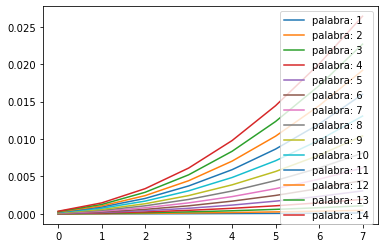

In [63]:
for i in range(14):
    plt.plot(data[i], label=f"resolucion: {i+1}")
    plt.legend()

In [3]:
df = pd.DataFrame(columns=['LP_bin', 'VD_bin'])

In [7]:
df.LP_bin = [0,0,0,0,0,0,0,0,0,0]
df.VD_bin = [0,0,0,0,0,0,0,0,0,0]

In [7]:
mutual_info_optimized(resolution(df, 100), ['LP_bin', 'VD_bin'], 1)

Entropia primera columna: 0.6383522843974425
Entropia segunda columna: 0.5003797555119865
Entropia conjunta: 1.1180052863560763


0.02072675355335285

In [9]:
mutual_info_optimized(resolution(df, 150), ['LP_bin', 'VD_bin'], 1)

Entropia primera columna: 0.7736364504765536
Entropia segunda columna: 0.6185150533286701
Entropia conjunta: 1.348515976071144


0.04363552773407964

In [10]:
df

,Unnamed: 0,LP,VD,LP_bin,VD_bin
0,0,0.004883,0.015259,0,0
1,1,0.001526,0.024109,0,0
2,2,-0.010681,0.031128,0,0
3,3,-0.022278,0.041809,0,0
4,4,-0.028076,0.045471,0,0
...,...,...,...,...,...
19847695,19847695,-0.005798,0.017395,0,0
19847696,19847696,-0.007019,0.024109,0,0
19847697,19847697,-0.000916,0.029602,0,0
19847698,19847698,0.007324,0.039368,0,0


(0.0, 2000.0)

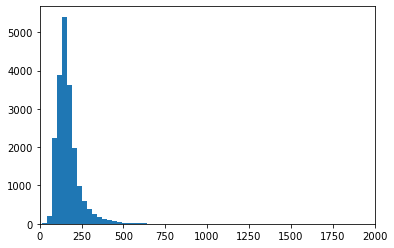

In [37]:
w = df.index[df.VD_bin > 0]
w = w[1:] - w[:-1]
plt.hist(w,bins=1000)
plt.xlim((0, 2000))

In [17]:
w

Int64Index([  97,  111,  130,  133,  135,  125,  156,  147,  132,  186,
            ...
             200,  214,  227,  500, 4951,  111,  154,  171,  178,  359],
           dtype='int64', length=32352)

In [ ]:
w = df.index[df.LP_bin > 0]

In [18]:
pd.Series(w).reindex()

0         97
1        111
2        130
3        133
4        135
        ... 
32347    111
32348    154
32349    171
32350    178
32351    359
Length: 32352, dtype: int64

In [38]:
threshold = 1000
w = df.index[df.LP_bin > 0]
w = (w[1:] - w[:-1]).to_list()
w.insert(0, np.inf)
df["distance"] = 0
df.loc[df.LP_bin > 0, "distance"] = w
df["LP2_bin"] = 0
df.loc[df.distance > threshold, "LP2_bin"] = 1

w = df.index[df.VD_bin > 0]
w = (w[1:] - w[:-1]).to_list()
w.insert(0, np.inf)
df["distance"] = 0
df.loc[df.VD_bin > 0, "distance"] = w
df["VD2_bin"] = 0
df.loc[df.distance > threshold, "VD2_bin"] = 1

In [40]:
df["VD2_bin"].sum()

1960

In [ ]:

df2 = get_bursts(df, 1000, ["LP_bin", "VD_bin"], ["LP_burst", "VD_burst"])


In [27]:
len(df.loc[df.LP_bin > 0, "distance"])

32353

In [32]:
df[df.LP_bin > 0]

,LP_bin,VD_bin,joined,distance
2878,1,0,1000,inf
2975,1,0,1000,97.0
3086,1,0,1000,111.0
3216,1,0,1000,130.0
3349,1,0,1000,133.0
...,...,...,...,...
19843981,1,0,1000,111.0
19844135,1,0,1000,154.0
19844306,1,0,1000,171.0
19844484,1,0,1000,178.0


In [29]:
w

Int64Index([  97,  111,  130,  133,  135,  125,  156,  147,  132,  186,
            ...
             200,  214,  227,  500, 4951,  111,  154,  171,  178,  359],
           dtype='int64', length=32352)

In [15]:
transfer_info(resolution(df,100), ['LP_bin', 'VD_bin'], 4)

Entropia primera columna: 2.02324110933116
Entropia segunda columna: 1.5134710660487392
Entropia conjunta: 3.4481154575867468


([0.043789500610948426, 0.05853875887066326],
 0.08859671779315281,
 [2.02324110933116, 1.5134710660487392],
 3.4481154575867468)

In [11]:
a = [1,2]

In [12]:
reversed(a)

In [13]:
for i in reversed(a):
    print(i)

2
1


In [23]:
a.insert(0,np.inf)

In [24]:
a

[inf, 10000, 1, 2]

In [6]:
col_names = [f"word_len {i}" for i in range(10)]
row_names = [f"resolution {i}" for i in range(10)]
data = {
    "transfer_info_col1_col2" : pd.DataFrame(columns = col_names, index = row_names),
    "mutual_info" : pd.DataFrame(columns = col_names, index = row_names),
    "col1_entropy" : pd.DataFrame(columns = col_names, index = row_names),
    "col2_entropy" : pd.DataFrame(columns = col_names, index = row_names),
    "joined_entropy" : pd.DataFrame(columns = col_names, index = row_names)
}
data["transfer_info_col1_col2"][:] = 0

In [7]:
data

{'transfer_info_col1_col2':              word_len 0 word_len 1 word_len 2 word_len 3 word_len 4  \
 resolution 0          0          0          0          0          0   
 resolution 1          0          0          0          0          0   
 resolution 2          0          0          0          0          0   
 resolution 3          0          0          0          0          0   
 resolution 4          0          0          0          0          0   
 resolution 5          0          0          0          0          0   
 resolution 6          0          0          0          0          0   
 resolution 7          0          0          0          0          0   
 resolution 8          0          0          0          0          0   
 resolution 9          0          0          0          0          0   
 
              word_len 5 word_len 6 word_len 7 word_len 8 word_len 9  
 resolution 0          0          0          0          0          0  
 resolution 1          0          0  